# Notebook 3: Assessing Module Fairness 

In 2016 researchers built an AI to distinguish melanoma from clinical images. The algorithm was trained on over 100,000 images. The photographs were labeled either "malignant" or "benign." The algorithm correctly identified 95% of the melanomas, but scientest Stephanie Dutchen pointed out that [95% of the images used for training were light skinned](https://blog.petrieflom.law.harvard.edu/2019/10/29/).

In the previous module, we classified skin lession photos using several different Machine Learning algorithms. 

How would these algorithms work in a broader context, deployed for people around the world? Would the model still perform well?

In today's module, we will determine whether or not our trained model is classifying fairly. We will:
*   Retrain our best model from the previous notebook
*   Classify images' skin tones based on RGB values
*   Compare our model's accuracy across different skin tones


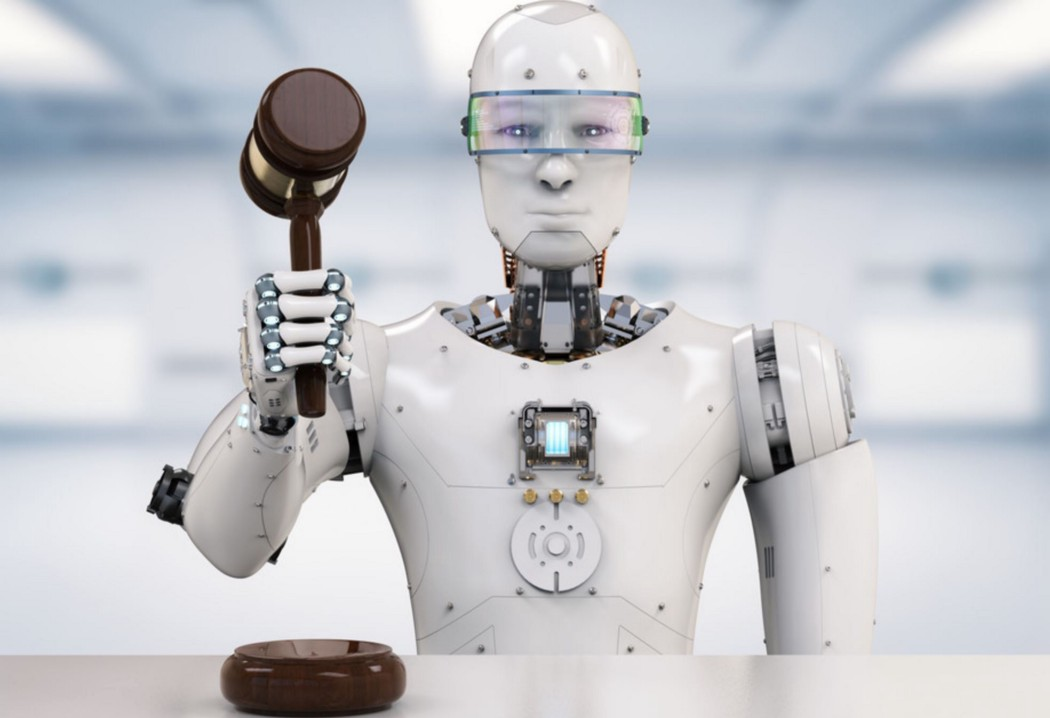

# What is Algorithmic Fairness? 

**Question:** How would you determine if an algorithm is fair?

Here's a definition from [Wikipedia](https://en.wikipedia.org/wiki/Fairness_(machine_learning):
*An algorithm is said to be fair... if its results are independent of given variables, especially those considered sensitive, such as the traits of individuals which should not correlate with the outcome (i.e. gender, ethnicity, sexual orientation, disability, etc).*

Algorithmic fairness is particularly important in instances where there can be potential harms of an unaccurate prediction. In the case of skin cancer diagnosis, there are assorted risks with producing false positives and false negatives. 

**Discuss:** Which of the traits listed traits do you think would be most relevent with skin lession photos? Why does fairness matter for this problem?



# Setup our Enivronment 

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
from google.colab.output import eval_js

import time
start_time = time.time()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

import keras
from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
from google.colab.patches import cv2_imshow
from copy import deepcopy
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet import MobileNet

!pip install hypopt
from hypopt import GridSearch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

!pip install -U opencv-contrib-python
import cv2

!pip install tensorflowjs 
import tensorflowjs as tfjs

from google.colab import files

import requests, io, zipfile

# Prepare data

images_1 = os.makedirs('images_1', exist_ok=True)
images_2= os.makedirs('images_2', exist_ok=True)
images_all= os.makedirs('images_all', exist_ok=True)

metadata_path = 'metadata.csv'
image_path_1 = 'images_1.zip'
image_path_2 = 'images_2.zip'
images_rgb_path = 'hmnist_8_8_RGB.csv'

!wget -O metadata.csv 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/metadata.csv'
!wget -O images_1.zip 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/images_1.zip'
!wget -O images_2.zip 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/images_2.zip'
!wget -O hmnist_8_8_RGB.csv 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/hmnist_8_8_RGB.csv'
!unzip -q images_1.zip -d images_1 
!unzip -q images_2.zip -d images_2 

!pip install patool
import patoolib

import os.path
from os import path

from distutils.dir_util import copy_tree

fromDirectory = 'images_1'
toDirectory = 'images_all'

copy_tree(fromDirectory, toDirectory)

fromDirectory = 'images_2'
toDirectory = 'images_all'

copy_tree(fromDirectory, toDirectory)

os.makedirs("static/js")
!wget -O static/js/skin_cancer_diagnosis_script.js 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/skin_cancer_diagnosis_script.js'
output = 'static/js/skin_cancer_diagnosis_script.js'

print("Downloaded Data")

     |████████████████████████████████| 57.4MB 72kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 112kB 15.1MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0
--2021-05-30 16:18:19--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20B)%20Skin%20Cancer%20Diagnosis/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553377 (540K) [text/csv]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>] 540.41K  --.-KB/s    in 0.005s  

2021-05-30 16:18:19 (96.4 MB/s) - ‘metadata.csv’ saved [553377/553377]

--2021-05-30 16:18:19--  https://storage.googleapis.com/inspir

In [ ]:
#@title If the previous cell fails to run, run this cell instead! { display-mode: "form" }
from google.colab.output import eval_js

import time
start_time = time.time()

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

import keras
from keras import backend as K
from tensorflow.keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
from google.colab.patches import cv2_imshow
from copy import deepcopy
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet import MobileNet

!pip install hypopt
from hypopt import GridSearch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

!pip install -U opencv-contrib-python
import cv2

!pip install tensorflowjs 
import tensorflowjs as tfjs

from google.colab import files

import requests, io, zipfile

# Prepare data

DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

metadata_url = 'https://drive.google.com/uc?id=1kmpa-Lnra-8KhEjj8r3nj9y4e53qcPGX'
metadata_path = os.path.join(DATA_ROOT, 'metadata.csv')
requests.get(metadata_url)
gdown.download(metadata_url, metadata_path, True)

images_1 = 'https://drive.google.com/uc?id=1HW5HbQ_OR7xUPWfw4yg1r_EbhDaCuOrj'
image_path_1 = os.path.join(DATA_ROOT, 'images_1.zip')
requests.get(images_1)
gdown.download(images_1, image_path_1, True)

images_2 = 'https://drive.google.com/uc?id=1VAbEVMKZmKyh9tpe9iVZ_XpTPLpxitwt'
image_path_2 = os.path.join(DATA_ROOT, 'images_2.zip')
requests.get(images_2)
gdown.download(images_2, image_path_2, True)

metadata_path = os.path.join(DATA_ROOT, 'metadata.csv')
image_path_1 = os.path.join(DATA_ROOT, 'images_1.zip')
image_path_2 = os.path.join(DATA_ROOT, 'images_2.zip')
images_rgb_path = os.path.join(DATA_ROOT, 'hmnist_8_8_RGB.csv')

!pip install patool
import patoolib

import os.path
from os import path

if path.exists(os.path.join(DATA_ROOT, 'images_1')) == False:
  patoolib.extract_archive(os.path.join(DATA_ROOT, 'images_1.zip'), outdir= os.path.join(DATA_ROOT, 'images_1') )

if path.exists(os.path.join(DATA_ROOT, 'images_2')) == False:
  patoolib.extract_archive(os.path.join(DATA_ROOT, 'images_2.zip'), outdir= os.path.join(DATA_ROOT, 'images_2') )

from distutils.dir_util import copy_tree

fromDirectory = os.path.join(DATA_ROOT, 'images_1')
toDirectory = os.path.join(DATA_ROOT, 'images_all')

copy_tree(fromDirectory, toDirectory)

fromDirectory = os.path.join(DATA_ROOT, 'images_2')
toDirectory = os.path.join(DATA_ROOT, 'images_all')

copy_tree(fromDirectory, toDirectory)

print("Downloaded Data")

# Preprocessing the Data 

In [ ]:
#@title Run this to preprocess our image data { display-mode: "form" }
metadata = pd.read_csv(metadata_path)
metadata['category'] = metadata['dx'].replace({'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6,})

# image width:  100, image height: 75
IMG_WIDTH = 100
IMG_HEIGHT = 75

X = []
X_g = []
y = []

for i in tqdm(range(len(metadata))):
  image_meta = metadata.iloc[i]
  path = os.path.join(toDirectory, image_meta['image_id'] + '.jpg')
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  
  img_g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  X_g.append(img_g)

  X.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) # transform image to RGB
  y.append(image_meta['category'])

X_g = np.array(X_g)
X = np.array(X)
y = np.array(y)

As before, we'll need to balance our dataset - this is particularly important today so that we can use accuracy as a reasonable metric. Choose one of the two options:

In [ ]:
sample_cap = 100

In [ ]:
#@title Option 1: Run this to reduce dataset size. This method caps each class at *sample_cap* samples. { display-mode: "form" }
objects = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_totals = [0,0,0,0,0,0,0]
iter_samples = [0,0,0,0,0,0,0]
indicies = []

for i in range(len(X)):
  class_totals[y[i]] += 1

print("Initial Class Samples")
print(class_totals)

for i in range(len(X)):
  if iter_samples[y[i]] != sample_cap:
    indicies.append(i)
    iter_samples[y[i]] += 1

X = X[indicies]
X_g = X_g[indicies]

y = y[indicies]

class_totals = [0,0,0,0,0,0,0]

for i in range(len(X)):
  class_totals[y[i]] += 1

print("Modified Class Samples")
print(class_totals)

Initial Class Samples
[327, 514, 1099, 115, 1113, 6705, 142]
Modified Class Samples
[100, 100, 100, 100, 100, 100, 100]


In [ ]:
#@title Option 2: Run this to reduce dataset size. This method only reduces the number of *nv* samples to be the same amount as the number of samples found in the second most prevalent class. { display-mode: "form" }
objects = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
class_totals = [0,0,0,0,0,0,0]

for i in range(len(X)):
  class_totals[y[i]] += 1

print("Initial Class Samples")
print(class_totals)

largest_index = class_totals.index(max(class_totals))
class_totals[largest_index] = 0

second_largest_val = max(class_totals)

indicies = []
iter = 0
for i in range(len(X)):
  if y[i] == largest_index:
    if iter != second_largest_val:
      indicies.append(i)
      iter += 1
    else:
      continue
  else:
    indicies.append(i)

class_totals = [0,0,0,0,0,0,0]

for i in range(len(X)):
  class_totals[y[i]] += 1

print("Modified Class Samples")
print(class_totals)

X = X[indicies]
X_g = X_g[indicies]

y = y[indicies]

# Re-implementing the Most Effective Model
Now, let's re-train the transfer learning model we built in Notebook 2. We'll examine its effectiveness for different skin tones.

In [ ]:
#@title Run this to Perform Data Augmentation { display-mode: "form" }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
X_g_train, X_g_test, y_train, y_test = train_test_split(X_g, y, test_size=0.4, random_state=101)

X_augmented = []
X_g_augmented = []

y_augmented = []

for i in tqdm(range(len(X_train))):
  transform = random.randint(0,1)
  if (transform == 0):
    # Flip the image across the y-axis
    X_augmented.append(cv2.flip(X_train[i],1))
    X_g_augmented.append(cv2.flip(X_g_train[i],1))
    y_augmented.append(y_train[i])
  else:
    # Zoom 33% into the image
    zoom = 0.33

    centerX,centerY=int(IMG_HEIGHT/2),int(IMG_WIDTH/2)
    radiusX,radiusY= int((1-zoom)*IMG_HEIGHT*2),int((1-zoom)*IMG_WIDTH*2)

    minX,maxX=centerX-radiusX,centerX+radiusX
    minY,maxY=centerY-radiusY,centerY+radiusY

    cropped = (X_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_augmented.append(new_img)

    cropped = (X_g_train[i])[minX:maxX, minY:maxY]
    new_img = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))
    X_g_augmented.append(new_img)

    y_augmented.append(y_train[i])

X_augmented = np.array(X_augmented)
X_g_augmented = np.array(X_g_augmented)

y_augmented = np.array(y_augmented)

X_train = np.vstack((X_train,X_augmented))
X_g_train = np.vstack((X_g_train,X_g_augmented))

y_train = np.append(y_train,y_augmented)

In [ ]:
#@title Run this to Define our Transfer Learning CNN Model { display-mode: "form" }
def transfer_learning_model():
  mobilenet_model = MobileNet(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, pooling="max")

  transfer_model = Sequential()
  transfer_model.add(mobilenet_model)
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(256, activation="relu"))
  transfer_model.add(Dropout(0.1))
  transfer_model.add(BatchNormalization())
  transfer_model.add(Dense(7, activation="softmax"))

  # initiate RMSprop optimizer
  opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

  # Let's train the model using RMSprop
  transfer_model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC()])

  return transfer_model

In [ ]:
#@title Transform our labels into One Hot encodings { display-mode: "form" }
y_train_roc = np.zeros((y_train.size, y_train.max().astype(int)+1))
y_train_roc[np.arange(y_train.size),y_train.astype(int)] = 1

y_test_roc = np.zeros((y_test.size, y_test.max().astype(int)+1))
y_test_roc[np.arange(y_test.size),y_test.astype(int)] = 1

**Exercise:** Set up and train the transfer model. 

In [ ]:
#Your Code Here
transfer_model = KerasClassifier(build_fn=transfer_learning_model, verbose=1,epochs=5)

transfer_model.fit(X_train.astype(np.float32), y_train_roc.astype(np.float32),
       validation_data=(X_test.astype(np.float32),y_test_roc.astype(np.float32))
       ,verbose=1)

transfer_model.predict()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
27/27 [==============================] - 44s 1s/step - loss: 2.2148 - auc_1: 0.5786 - val_loss: 2.5281 - val_auc_1: 0.6694
Epoch 2/5
27/27 [==============================] - 27s 990ms/step - loss: 1.0912 - auc_1: 0.7021 - val_loss: 2.0128 - val_auc_1: 0.7685
Epoch 3/5
27/27 [==============================] - 27s 993ms/step - loss: 0.7307 - auc_1: 0.7864 - val_loss: 1.7170 - val_auc_1: 0.8259
Epoch 4/5
27/27 [==============================] - 26s 974ms/step - loss: 0.4582 - auc_1: 0.8379 - val_loss: 1.5741 - val_auc_1: 0.8637
Epoch 5/5
27/27 [==============================] - 27s 983ms/step - loss: 0.3612 - auc_1: 0.8712 - val_loss: 1.4308 - val_auc_1: 0.8893


TypeError: ignored

In [ ]:
#@title Definition for the plot_cm() { display-mode: "form" }
def plot_cm(name, y_test_class, y_pred_class):
  cm = confusion_matrix(y_test_class, y_pred_class)
  classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

  classes_present = []
  for i in range(len(classes)):
    if i in y_pred_class or i in y_test_class:
      classes_present.append(classes[i])

  df_cm = pd.DataFrame(cm, index = [i for i in classes_present], columns = [i for i in classes_present])
  df_cm = df_cm.round(5)

  plt.figure(figsize = (12,8))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title(name + " Model Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

For simplicity, we'll use accuracy as a metric in this notebook. Later on, we'll compare the accuracy of our model for each of our skin tone classes. For now, output the confusion matrix and the overall accuracy of our model for the entire test set:

In [ ]:
# Your Code Here
y_pred = transfer_model.predict(X_test)
y_pred_proba = transfer_model.predict_proba(X_test)
transfer_model_cm = model_stats("Transfer_Model",y_test,y_pred,y_pred_proba)
plot_cm("Transfer", transfer_model_cm)

1/9 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


9/9 [==============================] - 1s 125ms/step


NameError: ignored

#Classifying Skin Tones

Now, we'll see how well our model performs for images of different skin tones.

We will classify each image in our test set based on a skin tone palette, shown below. We will use the average RGB pixel values to determine which skin tone each photo is closest to. 

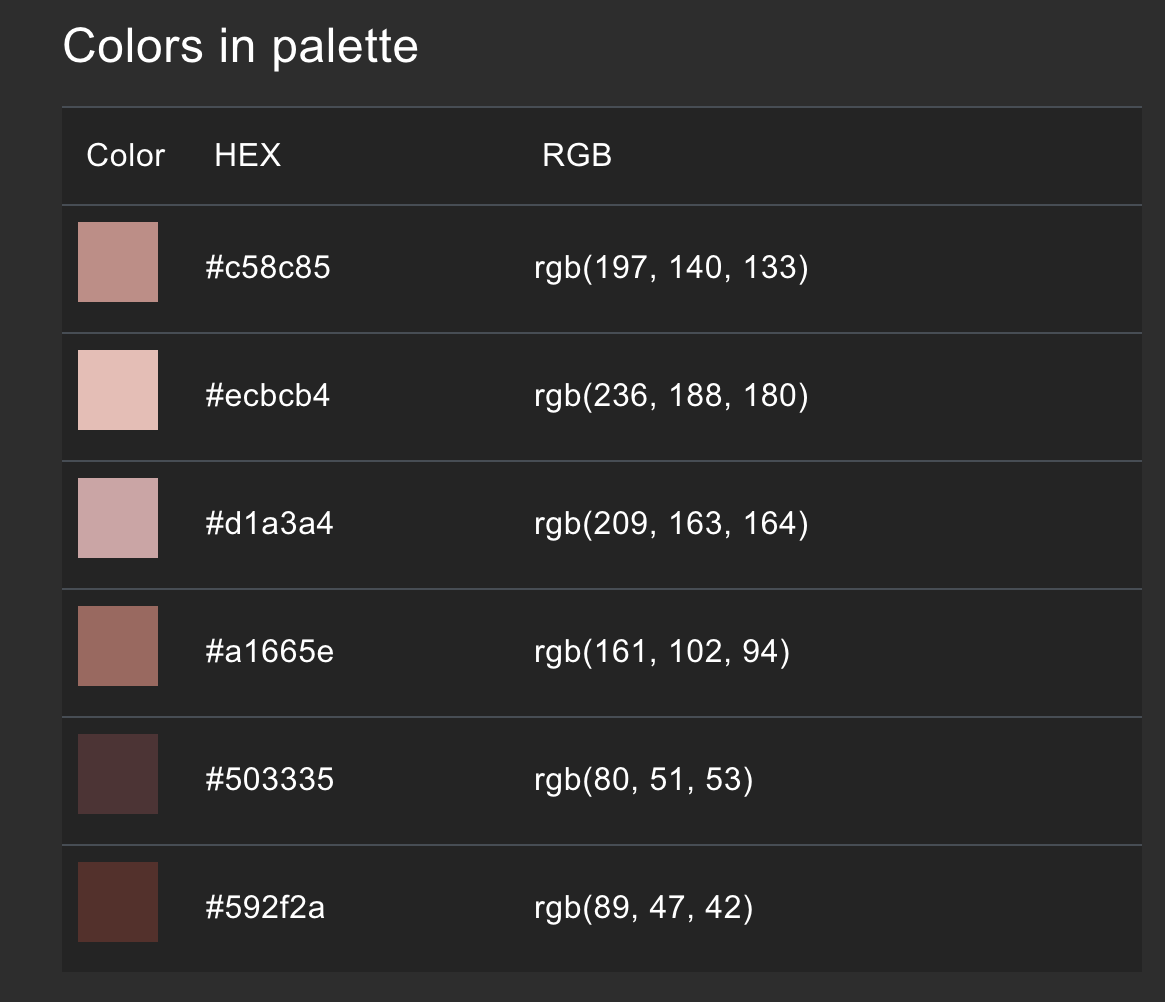

Run the following code to find the average red, green, and blue values of each image in the test set.

In [ ]:
# images of size 75x100 with 3 output rgb channels 
avg_rgb = X_test.mean(axis=2).mean(axis=1)
print(avg_rgb.shape)

(280, 3)


Now we have found the average red, green, and blue values for each image. We will use a clustering approach to find which of the six skin tones each image vector is closest to. We will use Euclidean Distance as our metric of similarity. 

We define the function closest_node(node,nodes) which takes in the average RGB values of a photo, and finds the closest skin color out of the nodes. 

In [ ]:
nodes = [[197, 140, 133], [236, 188, 180], [209, 163, 164], [161, 102, 94], [80, 51, 53], [89, 47, 42]]

# finds the closest color from the nodes array by index. 
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

You can try it out with a particular image:

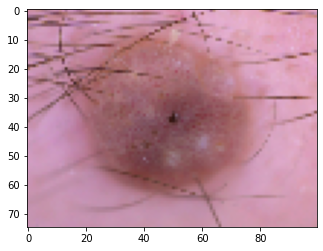

Skin tone class: 0


In [ ]:
img_num = 2 #Choose any image here
img = X_test[img_num]
plt.imshow(img) 
plt.show()
print ("Skin tone class:", closest_node(avg_rgb[img_num], nodes))

**Excercise:** Iterate through `avg_rgb`, use `closest_node` to find the skin class for each image, and append the results to a `skin_classes` list. 





In [ ]:
#Your Code Here
skin_classes = []
for img in avg_rgb:
  skin_classes.append(closest_node(img, nodes))

We will visualize the results of our findings using a bar chart. 

Text(0.5, 1.0, 'Frequency of Skin Classes')

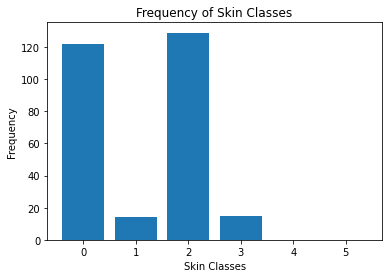

In [ ]:
#@title Run to plot skin class frequency in the test set

frequency = []
for i in range(6): 
  frequency.append(skin_classes.count(i))

plt.bar([0,1,2,3,4,5], frequency, label="skin class frequencies")

# The following commands add labels to our figure.
plt.xlabel('Skin Classes')
plt.ylabel('Frequency')
plt.title('Frequency of Skin Classes')

**Discuss:** What can we infer about our dataset based on the barchart? What could explain these patterns? How do you think this will impact the results of the model on each of these categories?  


#Measuring Fairness by Skin Tone
Now that we have the overall accuracy of our model, let's break it down further by skin tone classes within the test set. The code below will select the portions of `y_test` and `y_pred` for each class; complete it to show the accuracy and confusion matrix for each class.

Skin Class: 0
Number of images: 122


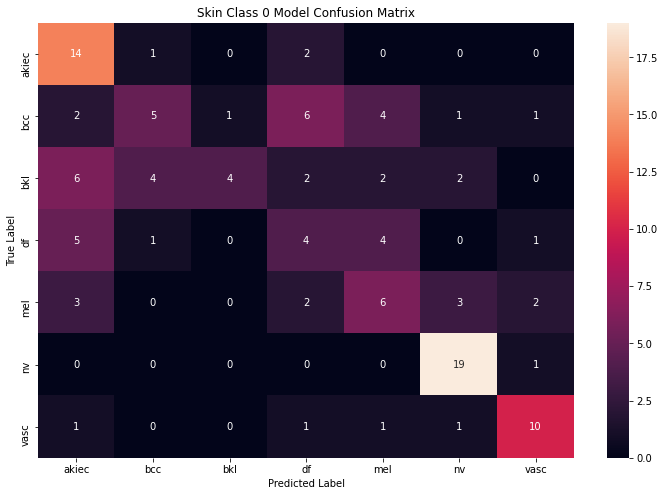

Skin Class: 1
Number of images: 14


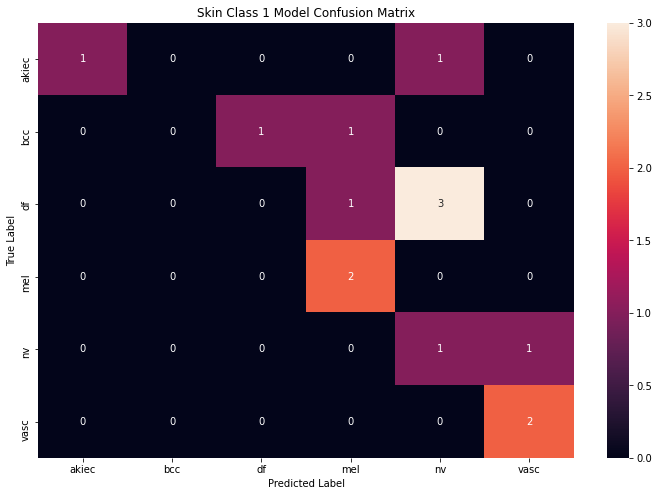

Skin Class: 2
Number of images: 129


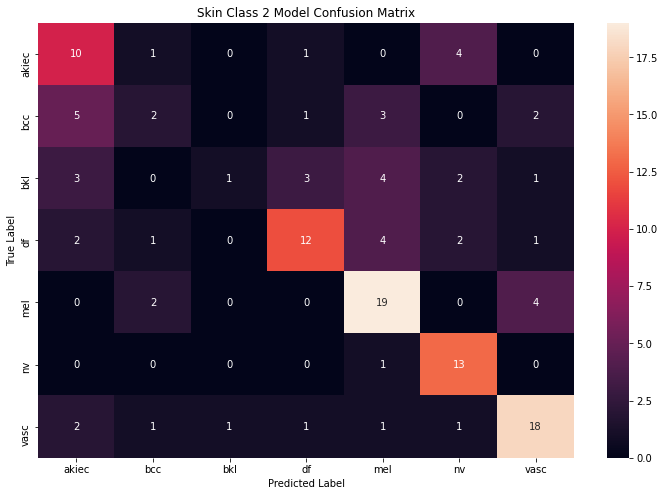

Skin Class: 3
Number of images: 15


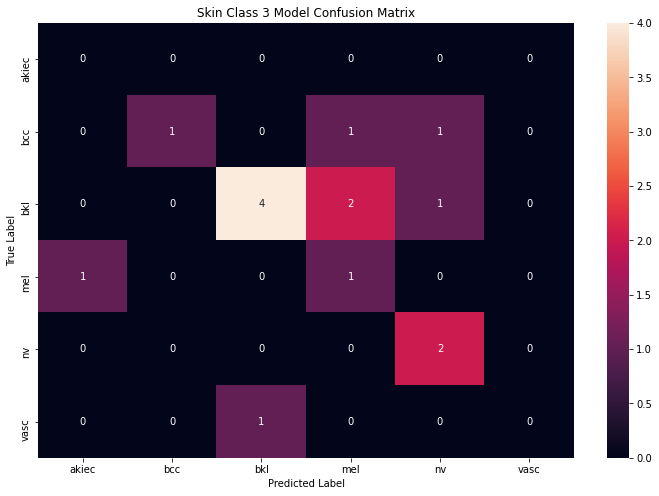

Skin Class: 4
Number of images: 0
Skin Class: 5
Number of images: 0


In [ ]:
for skin_class in range(6):
  print ("Skin Class: {}".format(skin_class))
  mask = (np.array(skin_classes) == skin_class)
  y_test_class = y_test[mask]
  y_pred_class = y_pred[mask]
  print ("Number of images: {}".format(len(y_test_class)))
  #YOUR CODE HERE to output accuracy and confusion matrix per class
  if(len(y_test_class) > 0):
    plot_cm("Skin Class %d" %skin_class, y_test_class, y_pred_class)
  

**Discuss:** 

*  What did you observe from the confusion matrices for the different skin type classifications? 
* Do you think the algorithm is fair? Why or why not? 
* What are some potential confounding variables to our transfer learning model that may have impacted how the model was trained? 

# Conclusion/Consequences

The rates of skin cancer has been on a 30-year climb. There are a lot of benefits of using Machine learning to diagnose Melanoma, such as being able to reach a much larger audience, especially where resources would otherwise be lacking. 

German researchers even found that convolutional neural networks detected potentially cancerous skin lesions better than the 58 dermatologists included in the study group([Oncol 2018 ](https://pubmed.ncbi.nlm.nih.gov/29846502/))

However, if the dataset used contains bias, the results of using such technology could be potentially dangerous. 


**Discuss :** What are some other potential consequences of using data that is not demographically representative? What are some solutions to creating less bias models? 

If the algorithm is not trained on a diverse set of images, then the algorithm when applied to real people also won't work well on a diverse audience. 

The risk of misdiagnosis is intensified by the statistics that while fair-skinned people are at the highest risk for contracting skin cancer, the mortality rate for African Americans is considerably higher.  Their five-year survival rate is 73 percent, compared with 90 percent for white Americans, according to the American Academy of Dermatology ([Lashbrook](https://www.theatlantic.com/health/archive/2018/08/machine-learning-dermatology-skin-color/567619/)). 
